# Capstone Project - The Battle of the Neighborhoods in Rome
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

The city of Rome is the capital of Italy, an unparalleled historical and cultural patrimony. 
Among stable citizens (just under 3 million in 2017) and tourists throughout the year for its mild climate (29 million according to 2018 statistics), it is an absolute _must visit_ among the cities of Europe, if not of the world.
According to this assumption, which is difficult to refute, it is of interest to evaluate the possibility of creating new commercial premises such as restaurants or pizzerias (or other types not sufficiently widespread to serve users), especially in parts of the city that are deficient in this type of structure (both in quantity and quality).

This project is therefore aimed at entrepreneurs in the restaurant sector who have the aim of identifying placements for new structures with prudent choices on where to create them.
The benefits of a prudent choice is in maximizing the ROI in the shortest possible time, therefore also being able to employ staff (reception/cooks/waiters), giving also workplaces to citizens.

In any case, the objectives can be qualified in the short term (identification of the best placement) and in the medium term (define whether to take over a business or request permits to build a new one).
The search for the best placement is not however based exclusively on the distribution of the population, but also on the actual presence of commercial activities in the areas of the city and their type. The logical combination of statistical information on the number of citizens and existing activities (also with an assessment of their degree of satisfaction) makes it possible to have an information pool of sure interest for the appropriate assessments.

In this project we will try to find an optimal location for a **new pizzeria in Rome**. 

Since there are lots of restaurants/pizzeria in Rome we will try to detect locations that are not already crowded with them, but however with high density of residents. 

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

From the urban point of view, Rome is divided in a decidedly particular way with four toponymic groups: the first are the districts (so called "rioni") that make up the historic center established since the Middle Ages (22 of limited territorial extension); then there are the neighborhoods (so called "quartieri") that surround the historic center, reaching as far as Ostia, that is, the sea (35 in all); finally, secondary groups are the suburbs and zones.
In this analysis we will focus on the first two (districts and neighborhoods) which comprise the majority of the residents and are of greater value as cleaning, transport, security and office presence.

Based on definition of our problem, factors that will influence our decision are:
* number of existing restaurants/pizzeria in the neighborhood (any type of restaurant)
* population and its density for each neighboorhood

We decided to use regularly defined neighborhoods in Rome (*rioni* and *quartieri*) as areas to check for the best location.


Following data sources will be needed to extract/generate the required information:
* demographic information taken from Wikipedia (https://it.wikipedia.org/wiki/Quartieri_di_Roma and https://it.wikipedia.org/wiki/Rioni_di_Roma)
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Google Maps API reverse geocoding**
* number of restaurants/pizzeria and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of Rome center will be obtained using **Google Maps API geocoding** of well known Rome location (Colosseo)

In [1]:
#Import libraries

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analysis
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import folium # map rendering library

from sklearn.cluster import KMeans # import k-means from clustering stage
from sklearn import preprocessing # library to standardize

import shapely.geometry
import pyproj
import math

Let's first find the latitude & longitude of Rome city center, using specific, well known address and Google Maps geocoding API.

In [2]:
# oscurare
google_api_key=''

In [3]:
import requests

def get_coordinates(api_key, address, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(api_key, address)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location'] # get geographical coordinates
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except:
        return [None, None]
    
address = 'Colosseo, Roma, Italia'
roma_center = get_coordinates(google_api_key, address)
print('Coordinates of the city center ({}): {}'.format(address, roma_center))

Coordinates of the city center (Colosseo, Roma, Italia): [41.8902102, 12.4922309]


In [4]:
def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print('Rome center longitude={}, latitude={}'.format(roma_center[1], roma_center[0]))
x, y = lonlat_to_xy(roma_center[1], roma_center[0])
print('Rome center UTM X={}, Y={}'.format(x, y))

Coordinate transformation check
-------------------------------
Rome center longitude=12.4922309, latitude=41.8902102
Rome center UTM X=291948.59102403687, Y=4640627.654790397


In [5]:
# Calcola latitudine e longitudine

def get_address(api_key, latitude, longitude, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&latlng={},{}'.format(google_api_key, latitude, longitude)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        address = results[0]['formatted_address']
        return address
    except:
        return None

In [6]:
# Coordinate del centro di Roma

addr = get_address(google_api_key, roma_center[0], roma_center[1])
print('Reverse geocoding check')
print('-----------------------')
print('Address of [{}, {}] is: {}'.format(roma_center[0], roma_center[1], addr))

Reverse geocoding check
-----------------------
Address of [41.8902102, 12.4922309] is: Piazza del Colosseo, 1, 00184 Roma RM, Italy


In [7]:
# Caricamento del dataframe di quartieri e rioni

df=pd.read_csv('Suddivisione Roma.csv', sep=";", encoding = "ISO-8859-1", decimal=",")
df.head()

,Tipo,Progressivo,Nome,Num. Abitanti,Densità
0,Quartiere,I,Flaminio,12155,10234.07
1,Quartiere,II,Parioli,13749,2894.16
2,Quartiere,III,Pinciano,20854,5847.68
3,Quartiere,IV,Salario,8301,17706.91
4,Quartiere,V,Nomentano,39245,12034.28


Let's now use Google Maps API to get approximate addresses of those locations.

In [8]:
# Troviamo latitudine e longitudine di quartieri e rioni (il loro centro)

address=[]

for i in range(df.shape[0]):
    complete_address = '{} {} {}, Roma'.format(df.iloc[i,0], df.iloc[i,1], df.iloc[i,2])
    print(' .', end='')
    
    geocode_url = "https://maps.googleapis.com/maps/api/geocode/json?address={}".format(complete_address)
    if google_api_key is not None:
        geocode_url = geocode_url + "&key={}".format(google_api_key)
        
    results = requests.get(geocode_url)
    results = results.json()
    
    if len(results['results']) == 0:
        output = {
            "Latitude": None,
            "Longitude": None,
        }
    else:    
        answer = results['results'][0]
        output = {
            "Latitude": answer.get('geometry').get('location').get('lat'),
            "Longitude": answer.get('geometry').get('location').get('lng'),
        }            
    
    address.append(output)
print(' done.')  

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


Looking good. Let's now place all this into a Pandas dataframe.

In [9]:
df1=pd.concat([df, pd.DataFrame(address).apply(pd.Series)],axis=1)

df1.head()

,Tipo,Progressivo,Nome,Num. Abitanti,Densità,Latitude,Longitude
0,Quartiere,I,Flaminio,12155,10234.07,41.925493,12.468154
1,Quartiere,II,Parioli,13749,2894.16,41.933805,12.492523
2,Quartiere,III,Pinciano,20854,5847.68,41.919778,12.486788
3,Quartiere,IV,Salario,8301,17706.91,41.914692,12.499691
4,Quartiere,V,Nomentano,39245,12034.28,41.911731,12.515463


In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Tipo           57 non-null     object 
 1   Progressivo    57 non-null     object 
 2   Nome           57 non-null     object 
 3   Num. Abitanti  57 non-null     int64  
 4   Densità        57 non-null     float64
 5   Latitude       57 non-null     float64
 6   Longitude      57 non-null     float64
dtypes: float64(3), int64(1), object(3)
memory usage: 3.2+ KB


In [11]:
neighborhoods=df1.copy()

In [12]:
neighborhoods.columns

Index(['Tipo', 'Progressivo', 'Nome ', 'Num. Abitanti', 'Densità', 'Latitude',
       'Longitude'],
      dtype='object')

Now plot che city map of Rome with its neighborhoods (*rioni* and *quartieri*)

In [13]:
# create map of Rome using latitude and longitude values
map_rome = folium.Map(location=[roma_center[0], roma_center[1]], zoom_start=10)
folium.Marker(roma_center, popup='Colosseo').add_to(map_rome)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Tipo'], neighborhoods['Nome ']):
    label = '{} {}'.format(borough, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue' if borough=='Quartiere' else 'red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rome)  
    
map_rome

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on restaurants/pizzeria in each neighborhood.

We're interested in venues in 'food' category. 

In [14]:
# Da oscurare
client_id=''
client_secret=''

We prefer to set a different radius for *quartieri* and *rioni* as the latter are on average very small compared to the former

In [15]:
# Parametri Foursquare API
version='20200526'
LIMIT=100
radius_quartiere=1500
radius_rione=500

In [16]:
def getNearbyVenues(types, names, latitudes, longitudes, category):
    
    venues_list=[]
    for tipo, name, lat, lng in zip(types, names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        if tipo=='Quartiere':
            radius=radius_quartiere
        else:
            radius=radius_rione
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            category,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print(' done.')  
    
    return(nearby_venues)

In [17]:

food_category = '4d4b7105d754a06374d81259' # 'Root' category for all food-related venues

rome_venues = getNearbyVenues(types=neighborhoods['Tipo'],
                              names=neighborhoods['Nome '],
                              latitudes=neighborhoods['Latitude'],
                              longitudes=neighborhoods['Longitude'],
                              category=food_category
                            )

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


In [18]:
print(rome_venues.shape)
rome_venues.head()

(3346, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Flaminio,41.925493,12.468154,Tiepolo,41.924321,12.469223,Diner
1,Flaminio,41.925493,12.468154,20MQ Design e Caffè,41.925191,12.470467,Café
2,Flaminio,41.925493,12.468154,Perilli,41.923424,12.469892,Italian Restaurant
3,Flaminio,41.925493,12.468154,Hotel Butterfly,41.927151,12.467478,Restaurant
4,Flaminio,41.925493,12.468154,Casa del Gusto,41.924065,12.470644,Italian Restaurant


In [19]:
rome_venues['Venue Category'].value_counts(normalize=True)

Italian Restaurant     0.312612
Café                   0.141961
Pizza Place            0.137179
Restaurant             0.058876
Sandwich Place         0.028093
                         ...   
Mac & Cheese Joint     0.000299
Taco Place             0.000299
Romagna Restaurant     0.000299
Szechuan Restaurant    0.000299
Hawaiian Restaurant    0.000299
Name: Venue Category, Length: 80, dtype: float64

In [20]:
print('There are {} uniques categories.'.format(len(rome_venues['Venue Category'].unique())))

There are 80 uniques categories.


In [21]:
print('Total number of food related places:', len(rome_venues))
print('Total numbers of pizzeria:',sum(rome_venues['Venue Category']=='Pizza Place'))
print('Percentage of pizzeria: {:.2f}%'.format(sum(rome_venues['Venue Category']=='Pizza Place') / len(rome_venues) * 100))
print('Average number of food related places in neighborhood:', np.array([len(r) for r in rome_venues]).mean())

Total number of food related places: 3346
Total numbers of pizzeria: 459
Percentage of pizzeria: 13.72%
Average number of food related places in neighborhood: 14.714285714285714


Let's now see all the collected restaurants in our area of interest on map, and let's also show pizzeria in different color.

In [22]:
# create map of Rome using latitude and longitude values
map_rome = folium.Map(location=[roma_center[0], roma_center[1]], zoom_start=11)
folium.Marker(roma_center, popup='Colosseo').add_to(map_rome)

# add markers to map
for res in rome_venues.to_numpy():
    lat = res[4]; lon = res[5]
    color = 'red' if res[6]=='Pizza Place' else 'blue'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_rome)
    
map_rome

In [23]:
rome_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Flaminio,41.925493,12.468154,Tiepolo,41.924321,12.469223,Diner
1,Flaminio,41.925493,12.468154,20MQ Design e Caffè,41.925191,12.470467,Café
2,Flaminio,41.925493,12.468154,Perilli,41.923424,12.469892,Italian Restaurant
3,Flaminio,41.925493,12.468154,Hotel Butterfly,41.927151,12.467478,Restaurant
4,Flaminio,41.925493,12.468154,Casa del Gusto,41.924065,12.470644,Italian Restaurant


In [24]:
# Number of pizzeria for each quartiere/rione
pizzerie=rome_venues[rome_venues['Venue Category']=='Pizza Place'].groupby('Neighborhood')['Venue Category'].count().to_frame()
pizzerie.columns=['Num. pizzerie']
pizzerie.sort_values(by='Num. pizzerie', ascending=False).head()

,Num. pizzerie
Neighborhood,
Gianicolense,19
Tiburtino,18
Appio Latino,17
Monte Sacro,16
Collatino,16


In [25]:
# Number of other places for food 
altro_food=rome_venues[rome_venues['Venue Category']!='Pizza Place'].groupby('Neighborhood')['Venue Category'].count().to_frame()
altro_food.columns=['Num. altro food']
altro_food.sort_values(by='Num. altro food', ascending=False).head()

,Num. altro food
Neighborhood,
Ponte,94
Parione,94
S. Eustachio,92
Salario,91
Pinciano,91


In [26]:
food_freq=neighborhoods.join(pizzerie, on='Nome ')

In [27]:
food_freq.head()

,Tipo,Progressivo,Nome,Num. Abitanti,Densità,Latitude,Longitude,Num. pizzerie
0,Quartiere,I,Flaminio,12155,10234.07,41.925493,12.468154,9.0
1,Quartiere,II,Parioli,13749,2894.16,41.933805,12.492523,3.0
2,Quartiere,III,Pinciano,20854,5847.68,41.919778,12.486788,9.0
3,Quartiere,IV,Salario,8301,17706.91,41.914692,12.499691,9.0
4,Quartiere,V,Nomentano,39245,12034.28,41.911731,12.515463,13.0


There's probably an issue because of float type for **Num. pizzerie**. Let's investigate...

In [28]:
food_freq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Tipo           57 non-null     object 
 1   Progressivo    57 non-null     object 
 2   Nome           57 non-null     object 
 3   Num. Abitanti  57 non-null     int64  
 4   Densità        57 non-null     float64
 5   Latitude       57 non-null     float64
 6   Longitude      57 non-null     float64
 7   Num. pizzerie  56 non-null     float64
dtypes: float64(4), int64(1), object(3)
memory usage: 3.7+ KB


In [29]:
food_freq[food_freq.isnull().values]

,Tipo,Progressivo,Nome,Num. Abitanti,Densità,Latitude,Longitude,Num. pizzerie
34,Quartiere,XXXV,Lido di Castel Fusano,1623,262.5,41.712955,12.340661,NaN


It's reasonable because that neighborhood is next to the seaside, with a very low population density

In [30]:
# Solve for NaN cases: set to zero where no pizzeria exist
food_freq.fillna(0, inplace=True)
food_freq=food_freq.astype({'Num. pizzerie':int})

In [31]:
food_freq.head()

,Tipo,Progressivo,Nome,Num. Abitanti,Densità,Latitude,Longitude,Num. pizzerie
0,Quartiere,I,Flaminio,12155,10234.07,41.925493,12.468154,9
1,Quartiere,II,Parioli,13749,2894.16,41.933805,12.492523,3
2,Quartiere,III,Pinciano,20854,5847.68,41.919778,12.486788,9
3,Quartiere,IV,Salario,8301,17706.91,41.914692,12.499691,9
4,Quartiere,V,Nomentano,39245,12034.28,41.911731,12.515463,13


In [32]:
food_freq=food_freq.join(altro_food, on='Nome ')

In [33]:
food_freq.head()

,Tipo,Progressivo,Nome,Num. Abitanti,Densità,Latitude,Longitude,Num. pizzerie,Num. altro food
0,Quartiere,I,Flaminio,12155,10234.07,41.925493,12.468154,9,80
1,Quartiere,II,Parioli,13749,2894.16,41.933805,12.492523,3,47
2,Quartiere,III,Pinciano,20854,5847.68,41.919778,12.486788,9,91
3,Quartiere,IV,Salario,8301,17706.91,41.914692,12.499691,9,91
4,Quartiere,V,Nomentano,39245,12034.28,41.911731,12.515463,13,87


Looking good. So now we have all the foods related places and pizzeria among them. 

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on optimal locations for a new pizzeria!

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Rome that have low foods-related places/pizzeria density, but with high population density.

In first step we have collected the required **data: location and type (category) of every food-related places/pizzeria in Rome**. We have also **identified pizzeria** (according to Foursquare categorization -> 'pizza place').

Therefore we will focus on most promising neighborhoods, according to previous "low/high" rules. We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods which should be a starting point for final exploration and search for optimal venue location by stakeholders.

## Analysis <a name="analysis"></a>

Let us now **cluster** neighborhoods to create **centers of zones containing good locations**. Those zones, their centers and addresses will be the final result of our analysis. 

In [34]:
X=food_freq[['Num. Abitanti','Densità','Num. pizzerie','Num. altro food']]

Data must be standardized because of their different level of magnitude

In [35]:
#Standardize data (mean=0 and variance=1)
X_scaled=preprocessing.scale(X)

In [36]:
X_scaled[0:5]

array([[-0.60713717,  0.08334249,  0.2023963 ,  1.12481525],
       [-0.54793577, -0.8926442 , -1.07944693, -0.13984553],
       [-0.28405502, -0.49991511,  0.2023963 ,  1.54636884],
       [-0.7502753 ,  1.07700486,  0.2023963 ,  1.54636884],
       [ 0.39898944,  0.32271613,  1.05695845,  1.39307662]])

Because we're searching for high population density and low density for food-related places, we need to invert the sign of standardized data for the latter to give an "high rate" to the four variables together.

In [37]:
X_scaled[:,2:4]=-X_scaled[:,2:4]

In [38]:
X_scaled[0:5]

array([[-0.60713717,  0.08334249, -0.2023963 , -1.12481525],
       [-0.54793577, -0.8926442 ,  1.07944693,  0.13984553],
       [-0.28405502, -0.49991511, -0.2023963 , -1.54636884],
       [-0.7502753 ,  1.07700486, -0.2023963 , -1.54636884],
       [ 0.39898944,  0.32271613, -1.05695845, -1.39307662]])

Apply the *elbow method* to K-Means algorithm to search for the best K clusters value.

In [39]:
# Elbow method
k=range(1,10)
WCSS=[]

for i in k:
    kmeans=KMeans(init = "k-means++", n_clusters = i, n_init = 12)
    yhat=kmeans.fit(X_scaled)
    WCSS.append(yhat.inertia_)

WCSS

[228.0,
 150.08649300105185,
 107.85292832449281,
 76.12513097416465,
 61.398573819454725,
 52.61841171135727,
 44.62557792807904,
 39.8050291184097,
 35.68459894677602]

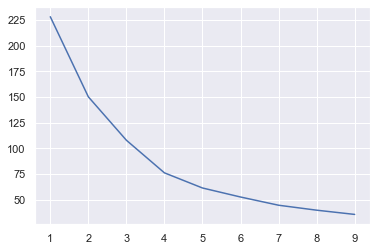

In [40]:
plt.plot(k, WCSS)

The most marked slope variation occurs with **4 clusters**

In [45]:
kclusters=4
kmeans=KMeans(init = "k-means++", n_clusters=kclusters, n_init = 12).fit(X_scaled)
kmeans.labels_

array([0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1,
       2, 1, 2, 2, 1, 1, 2, 2, 2, 0, 1, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 3,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2])

In [46]:
# add clustering labels
food_cluster=food_freq.copy()

In [47]:
food_cluster.insert(0, 'Cluster Labels', kmeans.labels_)

In [48]:
food_cluster.head()

,Cluster Labels,Tipo,Progressivo,Nome,Num. Abitanti,Densità,Latitude,Longitude,Num. pizzerie,Num. altro food
0,0,Quartiere,I,Flaminio,12155,10234.07,41.925493,12.468154,9,80
1,2,Quartiere,II,Parioli,13749,2894.16,41.933805,12.492523,3,47
2,0,Quartiere,III,Pinciano,20854,5847.68,41.919778,12.486788,9,91
3,0,Quartiere,IV,Salario,8301,17706.91,41.914692,12.499691,9,91
4,0,Quartiere,V,Nomentano,39245,12034.28,41.911731,12.515463,13,87


We're ready do plot the city map of Rome with the clustered neighborhoods on stated rules.

In [49]:
# create map of Rome using latitude and longitude values
map_rome = folium.Map(location=[roma_center[0], roma_center[1]], zoom_start=11)
folium.Marker(roma_center, popup='Colosseo').add_to(map_rome)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(food_cluster['Latitude'], food_cluster['Longitude'], food_cluster['Nome '], 
                                  food_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_rome)
       
map_rome

Our clusters represent groupings of candidate locations (neighborhoods).

Check now for some stats to further investigate the quality of our results.

In [121]:
food_cluster.groupby('Cluster Labels',axis=0).mean()

,Num. Abitanti,Densità,Latitude,Longitude,Num. pizzerie,Num. altro food
Cluster Labels,,,,,,
0,9384.764706,8770.505882,41.899254,12.486825,9.058824,77.647059
1,17709.000000,6114.447826,41.881190,12.487014,3.869565,29.434783
2,10737.000000,52045.560000,41.899735,12.474604,8.000000,92.000000
3,65440.000000,12864.951250,41.882899,12.493587,12.687500,48.187500


We've found that the cluster labeled as number 1 seems to be a good candidate for our new pizzeria: it has a high population mean density but a low mean number of pizzeria.

Go on to search further for specific neighborhoods that have the minimum amount of pizzeria among them.

In [144]:
food_1=food_cluster.loc[food_cluster['Cluster Labels'] == 1]

Try to limit the output further narrowing the set of pizzeria (less than the mean) and residents (more than the mean).

In [162]:
from statistics import mean
food_1[(food_1['Num. pizzerie']<mean(food_1['Num. pizzerie'])) & (food_1['Num. Abitanti']>mean(food_1['Num. Abitanti']))]

,Cluster Labels,Tipo,Progressivo,Nome,Num. Abitanti,Densità,Latitude,Longitude,Num. pizzerie,Num. altro food
14,1,Quartiere,XV,Della Vittoria,36068,5847.79,41.928446,12.452388,3,53
17,1,Quartiere,XVIII,Tor di Quinto,21118,4321.26,41.942710,12.478187,2,50
29,1,Quartiere,XXX,San Basilio,22711,6005.34,41.943194,12.584311,2,15
30,1,Quartiere,XXXI,Giuliano Dalmata,21350,2672.46,41.813034,12.501125,3,7
49,1,Rione,XIX,Celio,24167,15288.80,41.885994,12.493956,3,32


Wow! We've found a set of quartieri/rioni as good candidates for our project. They seem to be the best choice for our stated rules. Personally I suggest to avoid *San Basilio* just for a matter of degradation and security.

## Results and Discussion <a name="results"></a>

Our analysis shows that although there is a great number of food-related places in Rome, there are pockets of low pizzeria density. Our attention was focused on borough which offer a combination of low restaurant density and high population density.

Those location candidates (*quartieri* and *rioni*) were then clustered to create zones of interest which contain greatest number of location candidates. Addresses of centers of those zones were also generated using reverse geocoding to be used as markers/starting points for more detailed local analysis based on other factors.

Result of all are zones containing the best fit between population and pizzeria/food-related places density. This, of course, does not imply that these zones are actually optimal locations for a new pizzeria! Purpose of this analysis was to only provide info on areas in Rome not crowded with existing restaurants - it is entirely possible that there is a very good reason for small number of restaurants, reasons which would make them unsuitable for a new pizzeria regardless of lack of competition in the area. 

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Rome areas with low number of pizzeria in order to aid stakeholders in narrowing down the search for optimal location for a new one. By calculating food-related places/pizzeria density distribution from Foursquare data we have first identified general boroughs that justify further analysis, and then investigated further by clustering of those locations in order to create major zones of interest (containing greatest number of potential locations) to be used as starting points for final exploration by stakeholders.

Final decision on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.